# Natural Language Processing for the Fake News Challenge

## Main Imports

In [16]:
import time
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
!pip install transformers
import transformers

## Set up the data for preprocessing
### Load and sample the data

In [3]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [4]:
body_data.sample(10)

,Body ID,articleBody
1301,1957,Russian President Vladimir Putin last Friday u...
239,383,The sale of a private island in Lake Mälaren h...
622,945,Christian Bale will slip into a mock turtlenec...
339,523,"In a mass influx of basicness, it seems Durex ..."
180,283,UPDATE: ESPN has confirmed that no such panel ...
1248,1877,A woman detained by Lebanese authorities was n...
1032,1547,A picture of a letter to parents from a box of...
862,1301,Elusive graffiti artist Banksy’s cover was blo...
171,269,Islamic State militants have released a video ...
570,852,After a solid week of coming to terms with the...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [5]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
42697,2223,Piper Jaffray’s Gene Munster has issued a new ...,Video: Islamic State Claims to Have Captured U...,unrelated,unrelated
13853,826,"American photojournalist Luke Somers, held hos...",U.S. Hostage Luke Somers Killed During Yemen R...,discuss,related
44423,2296,North Korean despot Kim Jong-un has been guzzl...,GOP Rep. Duncan Hunter Claims 'At Least' 10 IS...,unrelated,unrelated
15261,919,Predator drones have started to fly over Raqqa...,Christian Bale in Talks to Play Steve Jobs (Ex...,unrelated,unrelated
5804,342,The handsomely charismatic Dr. Drake Ramoray f...,Kurt Sutter Announces Plans For ‘Sons Of Anarc...,unrelated,unrelated
31268,1742,Barack and Michelle Obama are in Riyadh today ...,Doubts cast over Nicaragua meteorite claim,unrelated,unrelated
44907,2307,The Pentagon has confirmed that the weapons we...,Video: Islamic State Claims to Have Captured U...,discuss,related
35598,1917,Apple originally planned for the Apple Watch t...,Rare meteorite impact causes blast in Nicaragu...,unrelated,unrelated
382,15,"Don't fucking cheat on Cassy, aka @NessLovnTre...",Unverified video shows beheading of aid worker...,unrelated,unrelated
33195,1827,"As reported by the Daily Star, the despot has ...",Kim Jong-un necks litres of rare SNAKE wine be...,discuss,related


### Splitting the dataset into train and validation sets

In [6]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
6437,Jeh Johnson: Politicians Shouldn't 'Feed The F...,Rome| An Italian expert studying a first centu...
24824,‘Wild Misinformation’: Brian Williams Explains...,Police will stop arresting people for low-leve...
35871,This Is a Truly Horrifying Story About a Spider,"Fear not arachnophobes, the story of Bunbury's..."
32753,Paul Rudd Helped Tackle A Violent Homophobe So...,"In 2015, there’s the quality-fake news and the..."
29402,Unconfirmed reports saying ISIS UK Hostage Dav...,Islamic State of Iraq and Syria leader Abu Bak...
10408,British-born rapper is main suspect in search ...,A man in his mid-to-late 50s is reportedly sla...
9695,Abdel Majed Abdel Bary Emerges as Suspect in F...,(CNN) -- Scratch Christian Bale off the list o...
38160,Caught a catfish record in Po: 127 kg and 2.67...,When a report went viral that NBC meteorologis...
45802,New Audio Shows Michael Brown Was Shot at 11 T...,Video messaging firm confirmed today the tape ...
1863,Daash Ebola transferred to Mosul {Google Trans...,A Chinese woman spent an entire week in a KFC ...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [7]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [8]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=50, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=50, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 100)
Val size:  (9995, 100)


## Evaluation Metrics

### Confusion Matrix

In [9]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [10]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display the Confusion Matrix and ROC Curve results

In [11]:
def display_results(model, val, y_val):

    y_pred = model.predict(val)

    print(metrics.classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)

    # convert to 0s and 1s for plotting ROC curve
    roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
    roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

    plot_roc_curve(roc_y_val, roc_y_pred)

## Training Models

### Support Vector Machine Classifier

In [12]:
def train_SVM(train, y_train, extractor):

    start = time.time()
    parameters = {
        'C': [1, 10],
        'gamma': [1, 'auto', 'scale']
    }
    # Tune hyperparameters  using Grid Search and a SVM model
    model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
    dump(model, extractor + '_SVM.joblib')

    end = time.time()
    print("Training took", end - start, "seconds")

    return model

### Train SVM using TF-IDF Features and display results

In [13]:
model = train_SVM(train, y_train, "tfidf")

Training took 6708.22327542305 seconds


              precision    recall  f1-score   support

     related       0.90      0.87      0.89      2767
   unrelated       0.95      0.96      0.96      7228

    accuracy                           0.94      9995
   macro avg       0.93      0.92      0.92      9995
weighted avg       0.94      0.94      0.94      9995



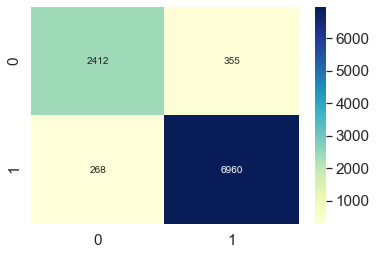

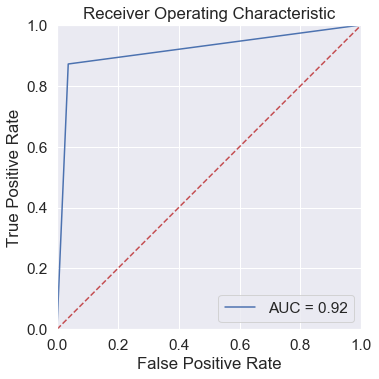

In [14]:
display_results(model, val, y_val)

# Tokenisation with BERT

### Load the model and tokeniser

In [17]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Embedding Retrieval

In [22]:
def get_embeddings(data):

    tokenized = tokenizer(list(data['Headline'][:250]), list(data['articleBody'][:250]),\
                      padding='max_length', truncation=True, return_tensors="pt")
    
    tokenized_text = tokenized['input_ids']

    with torch.no_grad():
        embeddings = model(tokenized_text)

    get_cls = lambda x: x[0][:, 0, :].squeeze()
    cls_embeddings = get_cls(embeddings)

    return cls_embeddings

In [23]:
train = get_embeddings(X_train)
val = get_embeddings(X_val)

### Train SVM using BERT Embeddings and display results

In [25]:
model = train_SVM(train[:250], y_train[:250], 'bert')

Training took 33.83731555938721 seconds


              precision    recall  f1-score   support

     related       0.57      0.06      0.11        64
   unrelated       0.75      0.98      0.85       186

    accuracy                           0.75       250
   macro avg       0.66      0.52      0.48       250
weighted avg       0.71      0.75      0.66       250



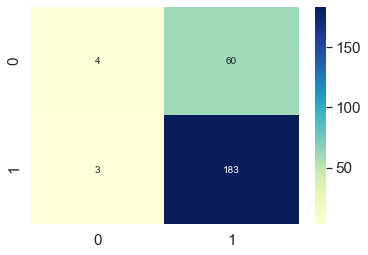

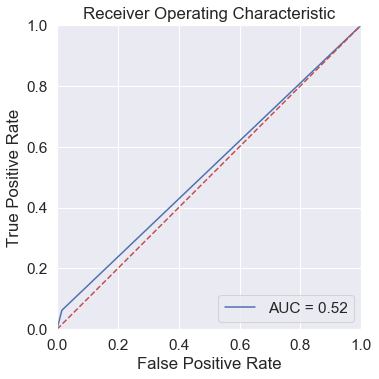

In [26]:
display_results(model, val[:250], y_val[:250])